In [ ]:
import os
import numpy as np
import pandas as pd
import PIL
import keras
from PIL import Image
from sklearn.utils import shuffle


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from skimage import feature, data, io, measure
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation,BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile


In [ ]:
zip_path = '/content/dataset.zip'
extract_path = '/content/dataset'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
root_folders = os.listdir(extract_path)
print("Root Folders Found:", root_folders)

Root Folders Found: ['dataset']


In [ ]:
dataset_path = os.path.join(extract_path, root_folders[0])

In [ ]:
class_folders = os.listdir(dataset_path)
print("Detected Class Folders:", class_folders)

Detected Class Folders: ['trash1', 'metal1', 'paper1', 'plastic1', 'cardboard1', 'glass1']


In [ ]:
for class_name in class_folders:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        print(f"Class: {class_name}, Images: {len(os.listdir(class_path))}")

Class: trash1, Images: 137
Class: metal1, Images: 410
Class: paper1, Images: 594
Class: plastic1, Images: 482
Class: cardboard1, Images: 403
Class: glass1, Images: 501


In [ ]:
batch_size_train = 20
batch_size_val = 10
batch_size_test = 25
num_classes = 6
STANDARD_SIZE = (224, 224)


In [ ]:

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_batches = train_datagen.flow_from_directory(
    dataset_path,
    target_size=STANDARD_SIZE,
    batch_size=batch_size_train,
    class_mode='categorical',
    subset='training')

val_batches = val_datagen.flow_from_directory(
    dataset_path,
    target_size=STANDARD_SIZE,
    batch_size=batch_size_val,
    class_mode='categorical',
    subset='validation')


Found 2527 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


In [ ]:

print("Class Indices:", train_batches.class_indices)

Class Indices: {'cardboard1': 0, 'glass1': 1, 'metal1': 2, 'paper1': 3, 'plastic1': 4, 'trash1': 5}



Class Distribution in Training Set:
Class: cardboard1, Training Samples: 403
Class: glass1, Training Samples: 501
Class: metal1, Training Samples: 410
Class: paper1, Training Samples: 594
Class: plastic1, Training Samples: 482
Class: trash1, Training Samples: 137

Class Distribution in Validation Set:
Class: cardboard1, Validation Samples: 80
Class: glass1, Validation Samples: 100
Class: metal1, Validation Samples: 82
Class: paper1, Validation Samples: 118
Class: plastic1, Validation Samples: 96
Class: trash1, Validation Samples: 27


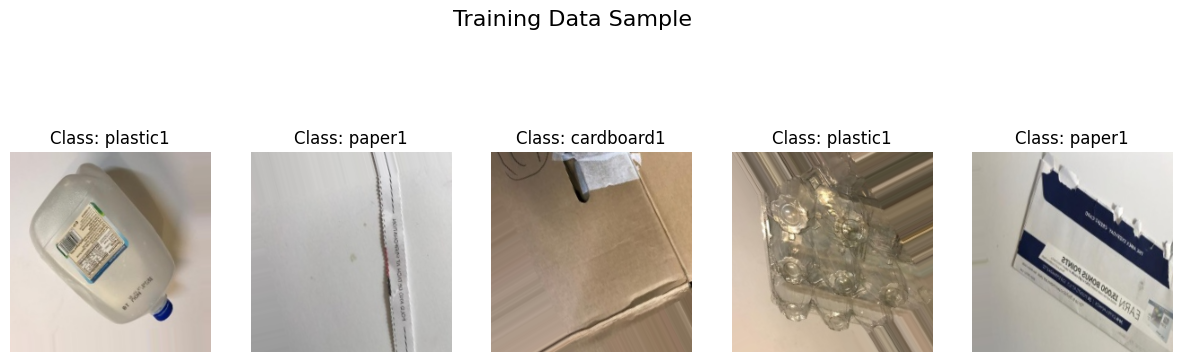

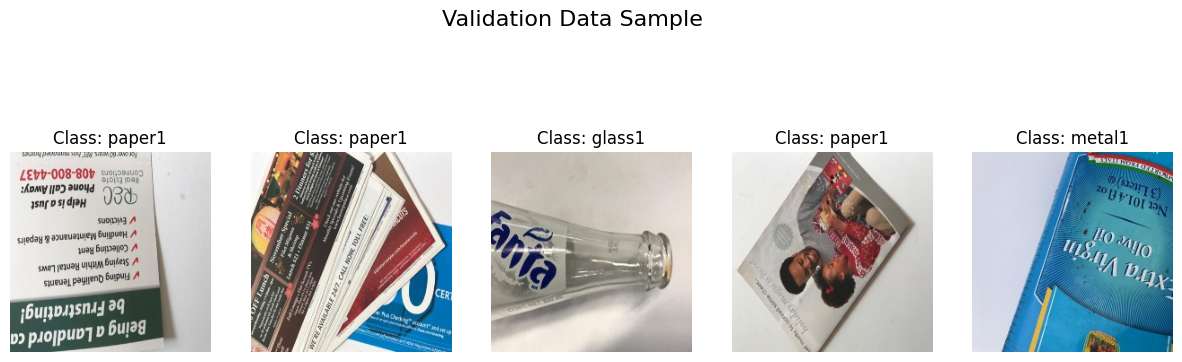


Class Indices: {'cardboard1': 0, 'glass1': 1, 'metal1': 2, 'paper1': 3, 'plastic1': 4, 'trash1': 5}


In [ ]:

print("\nClass Distribution in Training Set:")
for class_name, count in zip(train_batches.class_indices.keys(), np.bincount(train_batches.classes)):
    print(f"Class: {class_name}, Training Samples: {count}")

print("\nClass Distribution in Validation Set:")
for class_name, count in zip(val_batches.class_indices.keys(), np.bincount(val_batches.classes)):
    print(f"Class: {class_name}, Validation Samples: {count}")

def show_images_from_generator(generator, title):
    batch_images, batch_labels = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    fig.suptitle(title, fontsize=16)

    for i in range(5):
        axes[i].imshow(batch_images[i])
        label = np.argmax(batch_labels[i])
        axes[i].set_title(f"Class: {list(generator.class_indices.keys())[label]}")
        axes[i].axis('off')

    plt.show()

show_images_from_generator(train_batches, "Training Data Sample")
show_images_from_generator(val_batches, "Validation Data Sample")


print("\nClass Indices:", train_batches.class_indices)

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(6, activation='softmax')
])


class_labels = ['cardboard1', 'glass1', 'metal1', 'paper1', 'plastic1', 'trash1']
train_counts = np.array([323, 401, 328, 476, 386, 110])
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(6), y=np.repeat(np.arange(6), train_counts))
class_weights_dict = {i: class_weights[i] for i in range(6)}


model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,696,198 (105.65 MB)

 Trainable params: 20,059,398 (76.52 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

In [ ]:

history = model.fit(
    train_batches,
    validation_data=val_batches,
    epochs=50,
    class_weight=class_weights_dic
    callbacks=[lr_scheduler, early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 53s 373ms/step - accuracy: 0.2808 - loss: 2.1764 - val_accuracy: 0.6064 - val_loss: 1.0595 - learning_rate: 5.0000e-05
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 308ms/step - accuracy: 0.4874 - loss: 1.5109 - val_accuracy: 0.6123 - val_loss: 0.9790 - learning_rate: 5.0000e-05
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 325ms/step - accuracy: 0.5520 - loss: 1.2224 - val_accuracy: 0.5427 - val_loss: 1.2543 - learning_rate: 5.0000e-05
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.6224 - loss: 1.0617 - val_accuracy: 0.7137 - val_loss: 0.8137 - learning_rate: 5.0000e-05
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 306ms/step - accuracy: 0.6623 - loss: 0.9908 - val_accuracy: 0.7913 - val_loss: 0.6470 - learning_rate: 5.0000e-05
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 302ms/step - accuracy: 0.6937 - loss: 0.8816 - val_accuracy: 0.6620 - val_loss: 0.9486 - learning_rate: 5.0000e-05
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 38s 29

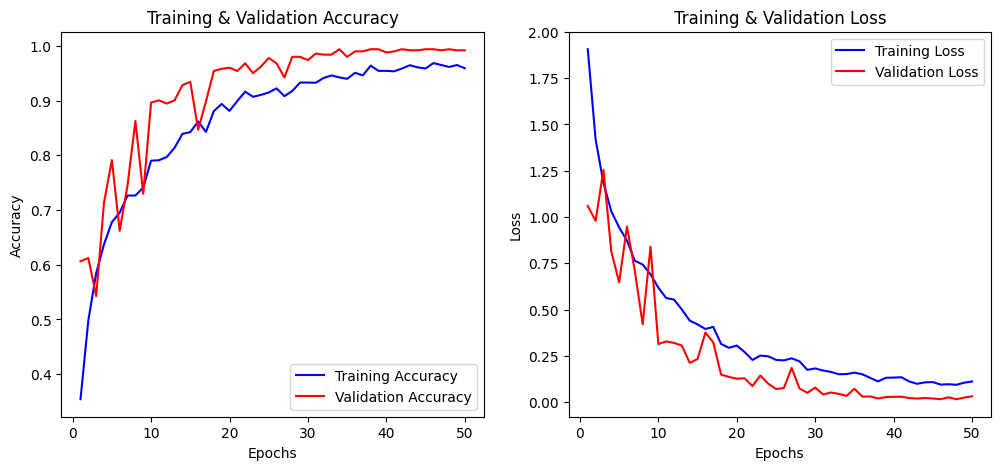

In [ ]:

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

=
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [ ]:
model.save("glass_classification_model.h5")
